<a href="https://colab.research.google.com/github/anonymous0897/ICML_Draft/blob/main/Transductive_TL_Code_CM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transductive TL Algorithm & Initial Performance Results:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C53919):

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)



In [4]:
data = cdc_diabetes_health_indicators.data
# data (as pandas dataframes)
X = data.features
y = data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [5]:
## Scaling the predictive data

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [6]:
data2 = pd.concat([X_scaled, y], axis=1)
data2

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.00,0.6,0.500000,1.0,0.0,0.666667,0.6,0.285714,0
1,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.50,0.0,0.000000,0.0,0.0,0.500000,1.0,0.000000,0
2,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.00,1.0,1.000000,1.0,0.0,0.666667,0.6,1.000000,0
3,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.0,0.000000,0.0,0.0,0.833333,0.4,0.714286,0
4,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.1,0.000000,0.0,0.0,0.833333,0.8,0.428571,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1.0,1.0,1.0,0.383721,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.166667,0.0,1.0,0.333333,1.0,0.857143,0
253676,1.0,1.0,1.0,0.069767,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.75,0.0,0.000000,1.0,0.0,0.833333,0.2,0.428571,1
253677,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.083333,0.8,0.142857,0
253678,1.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.000000,0.0,1.0,0.500000,0.8,0.000000,0


In [7]:
y.value_counts()

,count
Diabetes_binary,
0,218334
1,35346


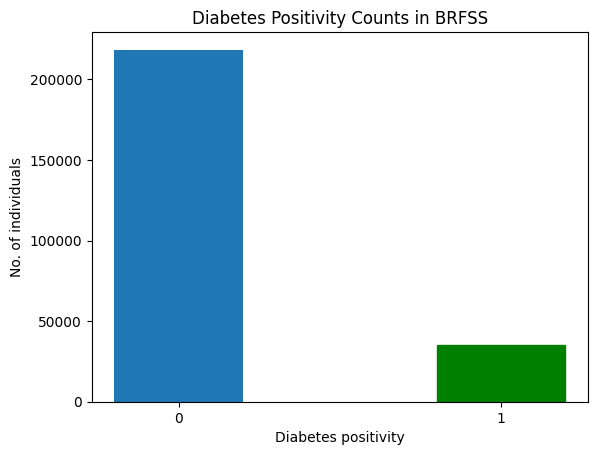

In [8]:
barlist = plt.bar([str(0),str(1)], y.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS")
plt.show()

In [9]:
X['Education'].value_counts()

,count
Education,
6,107325
5,69910
4,62750
3,9478
2,4043
1,174


In [10]:
X_scaled[19].value_counts()

,count
19,
1.0,107325
0.8,69910
0.6,62750
0.4,9478
0.2,4043
0.0,174


# Splitting for Source and Target Domains:


# Full Dataset:

In [11]:
data_S = data2[~data2[19].isin([0.0, 0.2])]  ## Source domain and classification
data_T = data2[data2[19].isin([0.0, 0.2])]  ## Target domain and classification

In [12]:
data_S

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.00,0.6,0.500000,1.0,0.0,0.666667,0.6,0.285714,0
1,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.50,0.0,0.000000,0.0,0.0,0.500000,1.0,0.000000,0
2,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.00,1.0,1.000000,1.0,0.0,0.666667,0.6,1.000000,0
3,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.0,0.000000,0.0,0.0,0.833333,0.4,0.714286,0
4,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.1,0.000000,0.0,0.0,0.833333,0.8,0.428571,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253674,0.0,0.0,1.0,0.174419,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.166667,1.0,0.571429,0
253675,1.0,1.0,1.0,0.383721,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.166667,0.0,1.0,0.333333,1.0,0.857143,0
253677,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.083333,0.8,0.142857,0
253678,1.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.000000,0.0,1.0,0.500000,0.8,0.000000,0


In [13]:
data_T

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
21,1.0,1.0,1.0,0.302326,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.00,0.5,1.000000,1.0,0.0,1.000000,0.2,0.285714,0
27,1.0,1.0,1.0,0.186047,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.75,0.0,0.000000,0.0,1.0,0.916667,0.2,0.428571,1
83,0.0,1.0,1.0,0.232558,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,1.0,0.0,1.000000,0.2,0.142857,1
95,1.0,1.0,1.0,0.151163,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.00,0.5,1.000000,1.0,0.0,0.666667,0.2,0.285714,1
190,1.0,0.0,1.0,0.267442,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.75,0.0,0.033333,1.0,1.0,0.666667,0.2,0.571429,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253645,1.0,0.0,1.0,0.267442,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.75,0.0,0.000000,0.0,1.0,0.166667,0.2,0.000000,0
253652,0.0,1.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.75,0.0,1.000000,0.0,1.0,0.833333,0.2,0.285714,1
253669,0.0,1.0,1.0,0.174419,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.00,0.0,0.100000,0.0,1.0,0.416667,0.2,0.428571,0
253672,1.0,0.0,1.0,0.209302,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.50,0.0,0.000000,0.0,1.0,0.916667,0.2,0.000000,0


## Source domain and task labels:

In [14]:
X_S_full = data_S.iloc[:, :21]
X_S_full       ## Source domain


y_S_full = data_S.iloc[:, 21]
y_S_full       ## Source classification (response)

,Diabetes_binary
0,0
1,0
2,0
3,0
4,0
...,...
253674,0
253675,0
253677,0
253678,0


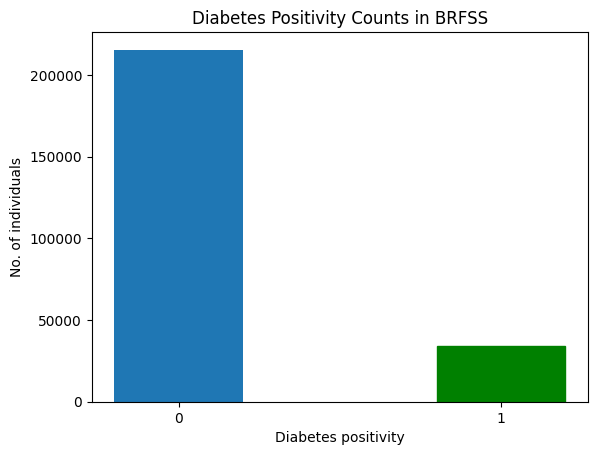

In [15]:
barlist_S = plt.bar([str(0),str(1)], y_S_full.value_counts(), width = 0.4)
barlist_S[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS")
plt.show()

## Target domain and task labels:

In [16]:
X_T_full = data_T.iloc[:, :21]
X_T_full       ## Target domain


y_T_full = data_T.iloc[:, 21]
y_T_full       ## Target classification (response)

,Diabetes_binary
21,0
27,1
83,1
95,1
190,0
...,...
253645,0
253652,1
253669,0
253672,0


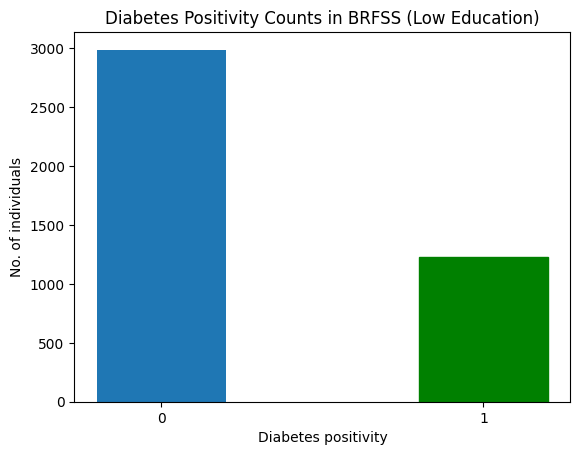

In [17]:
barlist_T = plt.bar([str(0),str(1)], y_T_full.value_counts(), width = 0.4)
barlist_T[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Low Education)")
plt.show()

## DNN & Transductive TL algorithms:

In [18]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  return model



def train_and_evaluate(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)


In [19]:
def Transductive_TL(model, X_test, y_test, domain):

    time_start = perf_counter()

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    # print('Confusion matrix:', conf_matrix)
    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tpr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tnr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")
    print('False Negative Rate:', fnr)

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

In [20]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_full, y_S_full, test_size=0.20, random_state=0)

In [21]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (199570, 21)
y_S_train: (199570,)
X_S_test: (49893, 21)
y_S_test: (49893,)


In [ ]:
model_source = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - AUC: 0.7866 - loss: 0.3339 - val_AUC: 0.8221 - val_loss: 0.3138
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - AUC: 0.8209 - loss: 0.3130 - val_AUC: 0.8235 - val_loss: 0.3103
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8266 - loss: 0.3111 - val_AUC: 0.8239 - val_loss: 0.3120
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8264 - loss: 0.3105 - val_AUC: 0.8254 - val_loss: 0.3122
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8273 - loss: 0.3090 - val_AUC: 0.8258 - val_loss: 0.3116
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8301 - loss: 0.3074 - val_AUC: 0.8250 - val_loss: 0.3097
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8298 - loss: 0.3080 - val_AUC: 0.8249 - val_loss: 0.3101
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8302 - loss: 0.3077 - val_AUC: 0.8259 - val_loss: 0.3110
Epoch 9/10
4990/4990 ━━━━━━━━━━━

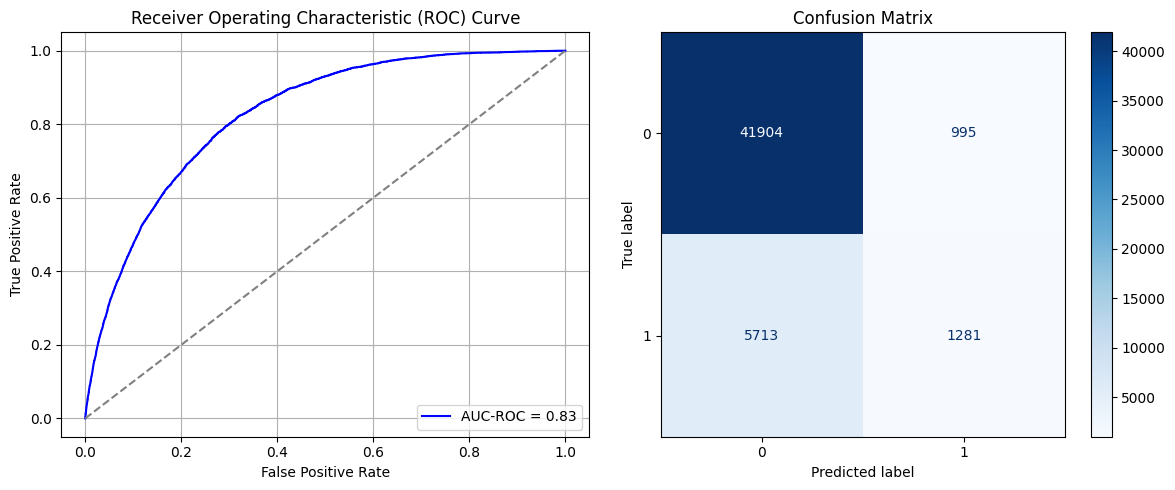

Best threshold based on F1-score: 0.2430160641670227
Time elapsed (performance): 184.62924799700068


In [ ]:
train_and_evaluate(model_source, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.763814197566147
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      2987
           1       0.63      0.30      0.40      1230

    accuracy                           0.74      4217
   macro avg       0.70      0.61      0.62      4217
weighted avg       0.72      0.74      0.71      4217

FPR 0.07030465349849348 TPR: 0.9296953465015065 FNR: 0.7048780487804878 TNR: 0.29512195121951224


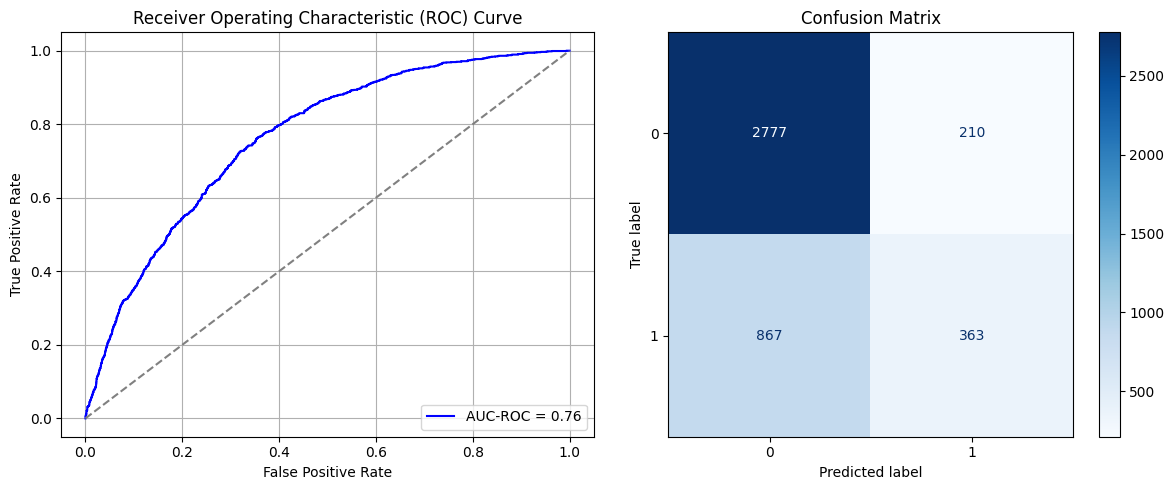

Best threshold based on F1-score: 0.27780336141586304
False Negative Rate: 0.7048780487804878
Time elapsed (performance): 1.457083727999816


In [ ]:
Transductive_TL(model_source, X_T_full, y_T_full, "Target")

# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [ ]:
data_S
data_S_majority = data_S[data_S['Diabetes_binary'].isin([0])]
data_S_minority = data_S[data_S['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

34116
215347


In [ ]:
np.random.seed(123)
data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=False)
# print(data_S_maj_rus)

data_S_SRS_RUS = pd.concat([data_S_maj_rus, data_S_minority])
# print(data_S_SRS_RUS)

X_S_SRS = data_S_SRS_RUS.iloc[:, :21]
X_S_SRS      ## Source domain


y_S_SRS = data_S_SRS_RUS.iloc[:, 21]
y_S_SRS       ## Source classification (response)

,Diabetes_binary
180301,0
223344,0
240588,0
90367,0
152534,0
...,...
253636,1
253659,1
253668,1
253670,1


In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Undersampling)")
plt.show()

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (54585, 21)
y_S_train: (54585,)
X_S_test: (13647, 21)
y_S_test: (13647,)


In [ ]:
model_source_SRS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7769 - loss: 0.5620 - val_AUC: 0.8175 - val_loss: 0.5269
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8177 - loss: 0.5179 - val_AUC: 0.8229 - val_loss: 0.5124
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8208 - loss: 0.5124 - val_AUC: 0.8244 - val_loss: 0.5123
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8219 - loss: 0.5113 - val_AUC: 0.8260 - val_loss: 0.5096
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8248 - loss: 0.5067 - val_AUC: 0.8275 - val_loss: 0.5071
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8259 - loss: 0.5071 - val_AUC: 0.8262 - val_loss: 0.5090
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8238 - loss: 0.5094 - val_AUC: 0.8288 - val_loss: 0.5114
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8280 - loss: 0.5038 - val_AUC: 0.8284 - val_loss: 0.5059
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━

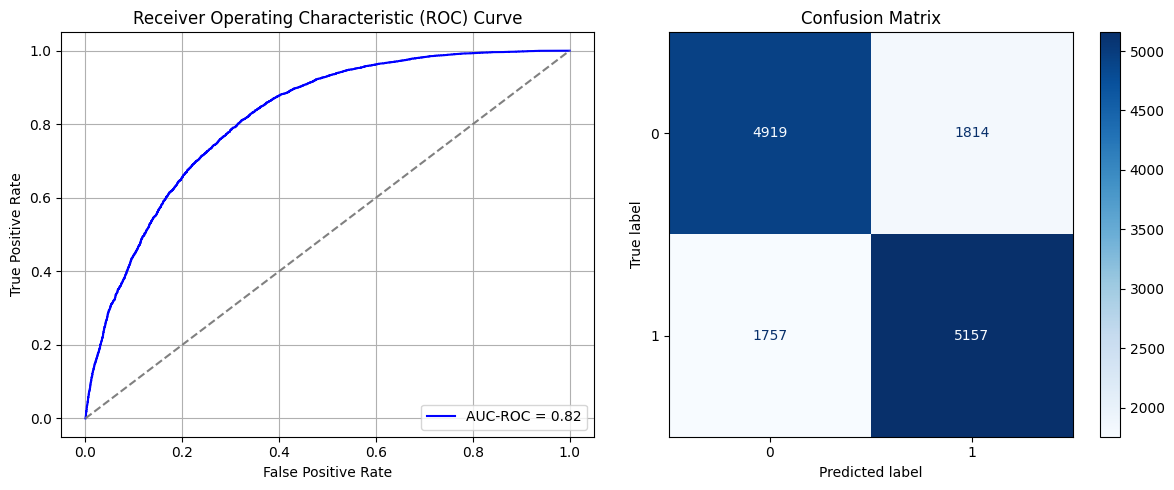

Best threshold based on F1-score: 0.3318638205528259
Time elapsed (performance): 44.24341545799962


In [ ]:
train_and_evaluate(model_source_SRS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7611715809156752
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.40      0.55      2987
           1       0.39      0.92      0.54      1230

    accuracy                           0.55      4217
   macro avg       0.66      0.66      0.55      4217
weighted avg       0.77      0.55      0.55      4217

FPR 0.6049548041513224 TPR: 0.3950451958486776 FNR: 0.07642276422764227 TNR: 0.9235772357723577


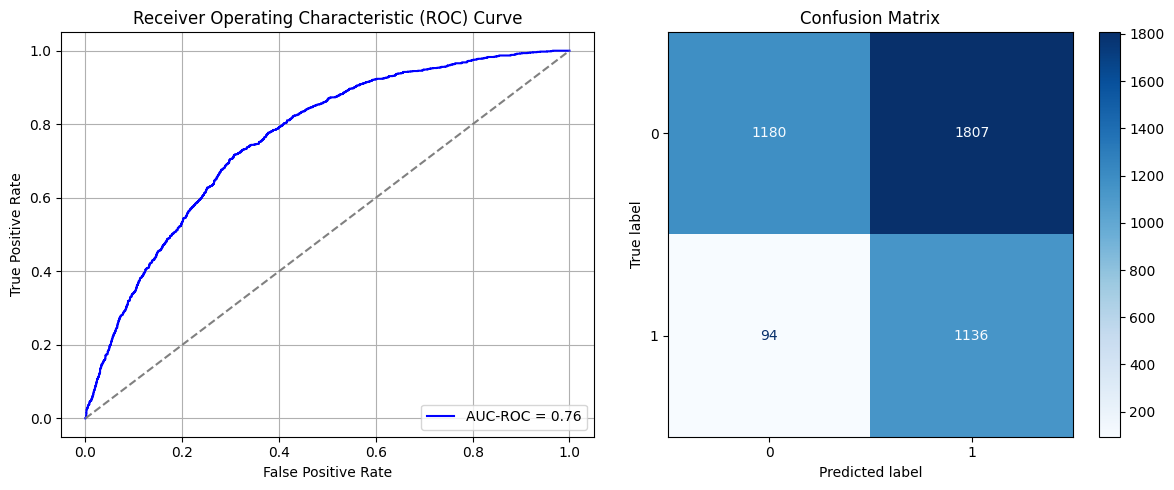

Best threshold based on F1-score: 0.9512280225753784
False Negative Rate: 0.07642276422764227
Time elapsed (performance): 0.9484202959993127


<ipython-input-112-825ae471d194>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
Transductive_TL(model_source_SRS, X_T_full, y_T_full, "Target")

## Simple Random Sampling with Replacement:

In [23]:
data_S
data_S_majority = data_S[data_S['Diabetes_binary'].isin([0])]
data_S_minority = data_S[data_S['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

34116
215347


In [ ]:
np.random.seed(123)
data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=True)
# print(data_S_maj_rus)

data_S_SRSwR_RUS = pd.concat([data_S_maj_rus, data_S_minority])
# print(data_S_SRS_RUS)

X_S_SRSwR = data_S_SRSwR_RUS.iloc[:, :21]
X_S_SRSwR      ## Source domain


y_S_SRSwR = data_S_SRSwR_RUS.iloc[:, 21]
y_S_SRSwR       ## Source classification (response)

,Diabetes_binary
19012,0
33080,0
21320,0
226502,0
140878,0
...,...
253636,1
253659,1
253668,1
253670,1


In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_SRSwR.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRSwR Undersampling)")
plt.show()

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRSwR, y_S_SRSwR, test_size=0.20, random_state=0)

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (54585, 21)
y_S_train: (54585,)
X_S_test: (13647, 21)
y_S_test: (13647,)


In [ ]:
model_source_SRSwR = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7781 - loss: 0.5614 - val_AUC: 0.8200 - val_loss: 0.5267
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8231 - loss: 0.5098 - val_AUC: 0.8249 - val_loss: 0.5109
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8248 - loss: 0.5083 - val_AUC: 0.8256 - val_loss: 0.5128
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8265 - loss: 0.5068 - val_AUC: 0.8270 - val_loss: 0.5077
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8317 - loss: 0.4993 - val_AUC: 0.8258 - val_loss: 0.5110
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8286 - loss: 0.5035 - val_AUC: 0.8272 - val_loss: 0.5073
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8332 - loss: 0.4986 - val_AUC: 0.8271 - val_loss: 0.5099
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8300 - loss: 0.5022 - val_AUC: 0.8268 - val_loss: 0.5072
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━

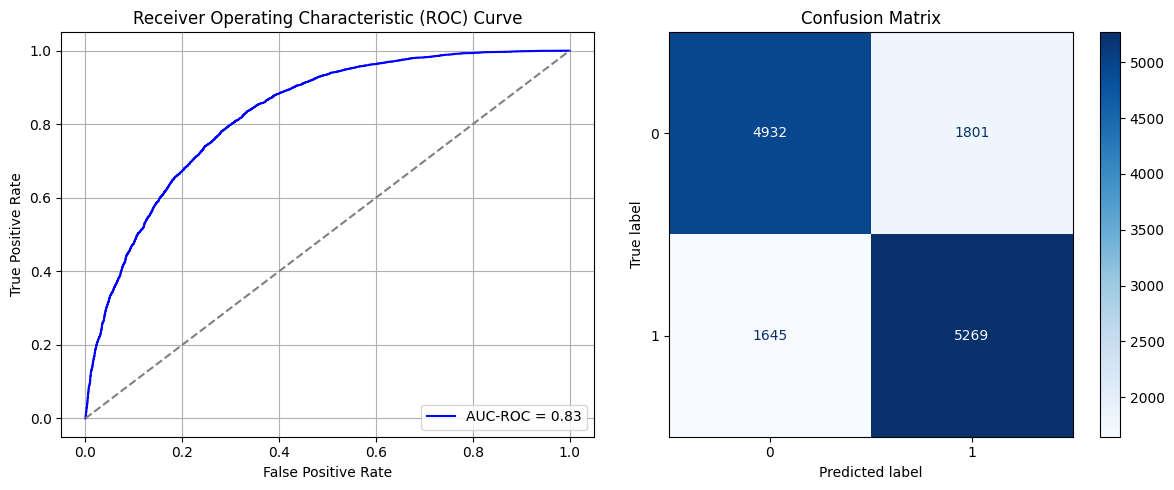

Best threshold based on F1-score: 0.3378368020057678
Time elapsed (performance): 49.523137326000324


In [ ]:
train_and_evaluate(model_source_SRSwR, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7555063813108838
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.45      0.60      2987
           1       0.40      0.90      0.55      1230

    accuracy                           0.58      4217
   macro avg       0.66      0.67      0.58      4217
weighted avg       0.76      0.58      0.59      4217

FPR 0.5523937060595916 TPR: 0.4476062939404084 FNR: 0.1024390243902439 TNR: 0.8975609756097561


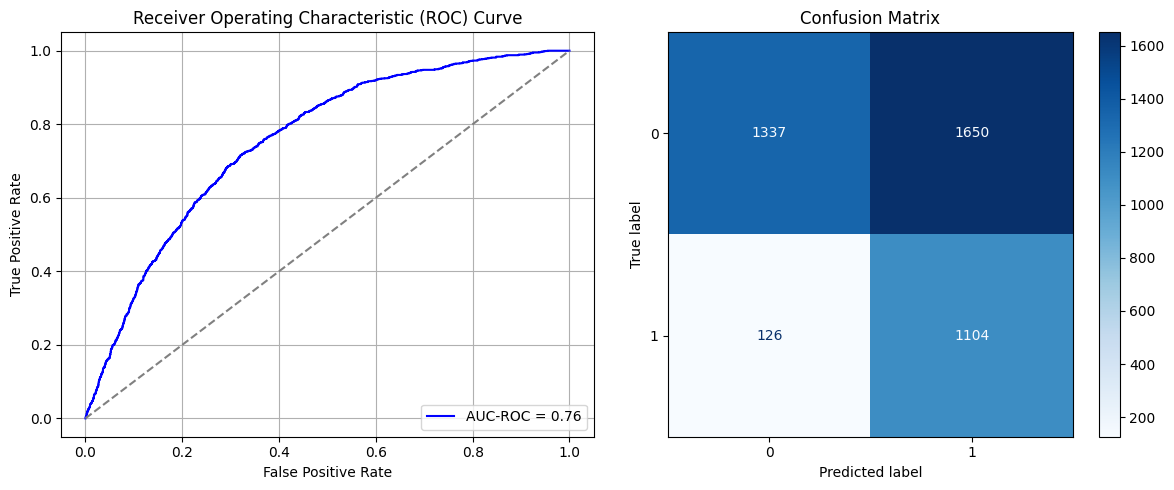

Best threshold based on F1-score: 0.6855422854423523
False Negative Rate: 0.1024390243902439
Time elapsed (performance): 0.9596608470001229


In [ ]:
Transductive_TL(model_source_SRSwR, X_T_full, y_T_full, "Target")

## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

In [24]:
import random

k = oversample_size/undersample_size
print(k)

np.random.seed(123)
start = random.randint(1, int(k))
print(start)


6.31219955446125
3


In [25]:
data_S_majority.iloc[[1]]

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
1,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.5,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0


In [26]:
Row = []

for i in range(undersample_size):
  row = start+int(k*i)-1
  Row.append(row)

# print(Row)

data_S_maj_rus = pd.DataFrame()
data_S_maj_rus = data_S_majority.iloc[Row]

data_S_maj_rus


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
2,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.00,1.000000,1.000000,1.0,0.0,0.666667,0.6,1.000000,0
9,0.0,0.0,1.0,0.139535,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.25,0.000000,0.000000,0.0,1.0,0.583333,0.6,0.285714,0
18,0.0,0.0,0.0,0.127907,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.25,0.500000,0.000000,0.0,0.0,0.083333,1.0,0.857143,0
29,0.0,1.0,1.0,0.220930,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.00,0.000000,0.000000,0.0,1.0,0.916667,1.0,1.000000,0
38,0.0,0.0,1.0,0.162791,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.00,0.000000,0.033333,0.0,1.0,0.250000,0.8,0.285714,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253641,0.0,1.0,1.0,0.162791,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.50,0.000000,0.000000,0.0,0.0,0.916667,0.6,0.428571,0
253648,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.50,0.200000,0.466667,0.0,1.0,0.333333,0.8,0.000000,0
253656,0.0,0.0,1.0,0.151163,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.00,0.000000,0.000000,0.0,0.0,0.250000,1.0,1.000000,0
253663,0.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.25,0.000000,1.000000,0.0,0.0,0.333333,1.0,0.142857,0


In [ ]:
data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
# print(data_S_SRS_RUS)

X_S_Sy = data_S_Sy_RUS.iloc[:, :21]
X_S_Sy      ## Source domain


y_S_Sy = data_S_Sy_RUS.iloc[:, 21]
y_S_Sy       ## Source classification (response)

,Diabetes_binary
5,0
14,0
22,0
33,0
42,0
...,...
253636,1
253659,1
253668,1
253670,1


In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Undersampling)")
plt.show()

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (54585, 21)
y_S_train: (54585,)
X_S_test: (13647, 21)
y_S_test: (13647,)


In [ ]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7888 - loss: 0.5533 - val_AUC: 0.8194 - val_loss: 0.5230
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8178 - loss: 0.5173 - val_AUC: 0.8227 - val_loss: 0.5160
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8219 - loss: 0.5120 - val_AUC: 0.8245 - val_loss: 0.5101
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8199 - loss: 0.5141 - val_AUC: 0.8248 - val_loss: 0.5103
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8234 - loss: 0.5088 - val_AUC: 0.8245 - val_loss: 0.5102
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8319 - loss: 0.4995 - val_AUC: 0.8260 - val_loss: 0.5100
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8285 - loss: 0.5042 - val_AUC: 0.8264 - val_loss: 0.5081
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8274 - loss: 0.5046 - val_AUC: 0.8262 - val_loss: 0.5081
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━

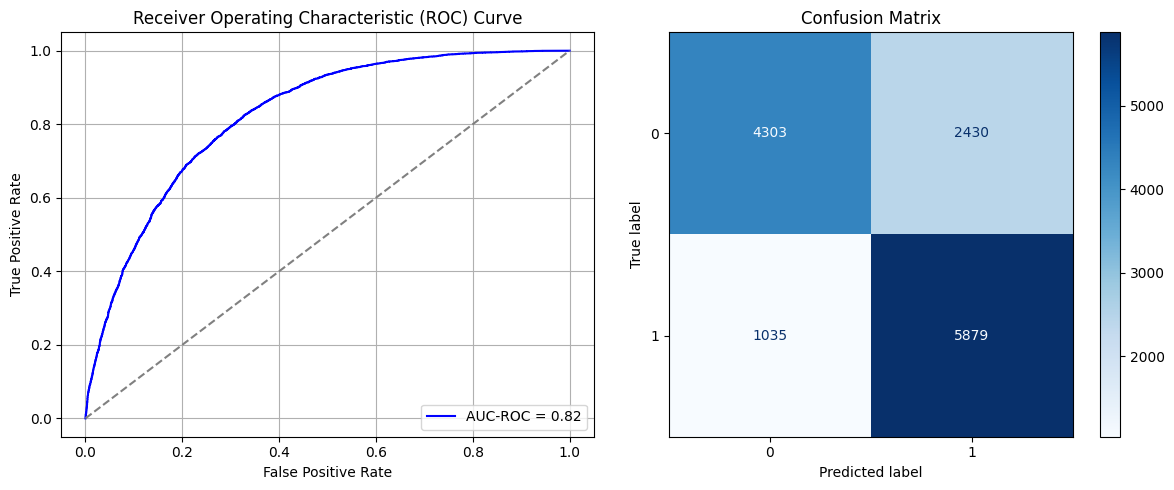

Best threshold based on F1-score: 0.4637789726257324
Time elapsed (performance): 46.99742136699933


In [ ]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.7599258031415266
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.32      0.48      2987
           1       0.36      0.94      0.53      1230

    accuracy                           0.50      4217
   macro avg       0.65      0.63      0.50      4217
weighted avg       0.77      0.50      0.49      4217

FPR 0.6782725142283227 TPR: 0.3217274857716773 FNR: 0.056910569105691054 TNR: 0.943089430894309


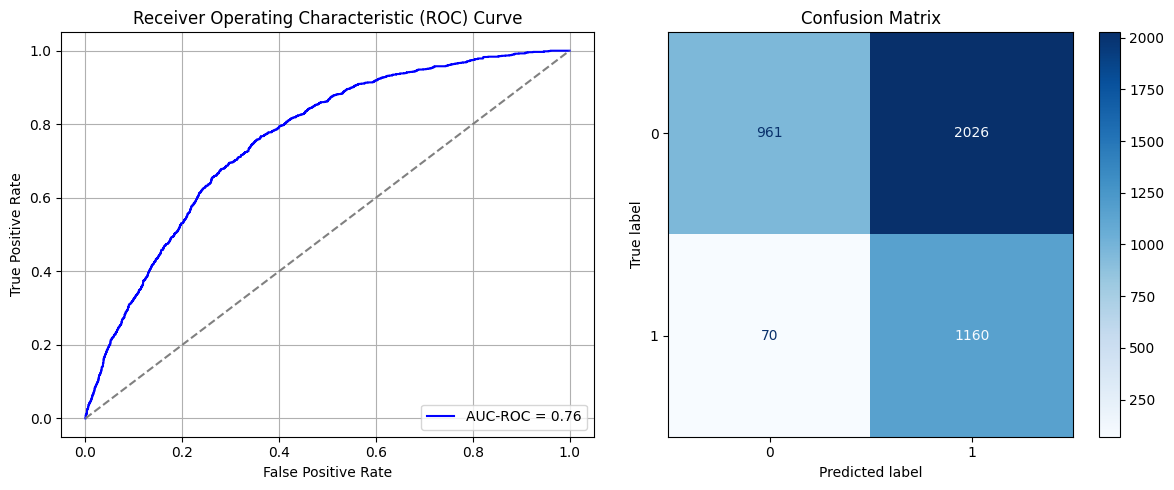

Best threshold based on F1-score: 0.7209070324897766
False Negative Rate: 0.056910569105691054
Time elapsed (performance): 0.9598285460006082


In [ ]:
Transductive_TL(model_source_Sy, X_T_full, y_T_full, "Target")

## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

In [ ]:
import random

m = 10

k = oversample_size/undersample_size * m
print(k)

np.random.seed(123)
start = random.sample(range(1, int(k)), 10)
# random.randint(1, int(k))
print(start)

63.1219955446125
[55, 53, 15, 35, 20, 5, 2, 23, 19, 13]


In [ ]:
Row = []

for j in range(len(start)):
  for i in range(int(undersample_size/m)):
    row = start[j]+int(k*i)-1
    Row.append(row)

# print(Row)

data_S_maj_rus = pd.DataFrame()
data_S_maj_rus = data_S_majority.iloc[Row]

data_S_maj_rus

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
72,0.0,0.0,1.0,0.232558,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.50,0.000000,0.000000,0.0,0.0,0.500000,0.6,0.285714,0
149,0.0,0.0,1.0,0.116279,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.000000,0.000000,0.0,1.0,0.916667,0.6,0.714286,0
231,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.25,0.000000,0.000000,0.0,0.0,0.416667,0.8,1.000000,0
314,1.0,1.0,1.0,0.127907,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.50,0.000000,0.000000,0.0,0.0,1.000000,0.4,0.000000,0
405,1.0,0.0,1.0,0.197674,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.75,0.166667,0.233333,1.0,0.0,0.583333,0.6,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253239,0.0,1.0,1.0,0.104651,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.50,0.233333,0.000000,0.0,0.0,0.083333,0.8,0.285714,0
253329,0.0,0.0,1.0,0.093023,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.50,0.000000,0.000000,0.0,0.0,0.500000,1.0,0.428571,0
253409,0.0,0.0,1.0,0.139535,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.00,0.000000,0.000000,0.0,1.0,0.666667,1.0,0.428571,0
253490,1.0,1.0,1.0,0.197674,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.000000,0.100000,0.0,0.0,0.166667,0.6,0.285714,0


In [ ]:
data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
# print(data_S_SRS_RUS)

X_S_Sy = data_S_Sy_RUS.iloc[:, :21]
X_S_Sy      ## Source domain


y_S_Sy = data_S_Sy_RUS.iloc[:, 21]
y_S_Sy       ## Source classification (response)

,Diabetes_binary
72,0
149,0
231,0
314,0
405,0
...,...
253636,1
253659,1
253668,1
253670,1


In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Multiple Systematic Undersampling)")
plt.show()

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (54580, 21)
y_S_train: (54580,)
X_S_test: (13646, 21)
y_S_test: (13646,)


In [ ]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7901 - loss: 0.5545 - val_AUC: 0.8218 - val_loss: 0.5161
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8176 - loss: 0.5165 - val_AUC: 0.8261 - val_loss: 0.5084
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8263 - loss: 0.5056 - val_AUC: 0.8290 - val_loss: 0.5047
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8216 - loss: 0.5116 - val_AUC: 0.8281 - val_loss: 0.5060
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8294 - loss: 0.5028 - val_AUC: 0.8292 - val_loss: 0.5050
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8263 - loss: 0.5062 - val_AUC: 0.8295 - val_loss: 0.5060
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8273 - loss: 0.5053 - val_AUC: 0.8303 - val_loss: 0.5029
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8328 - loss: 0.4970 - val_AUC: 0.8296 - val_loss: 0.5038
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━

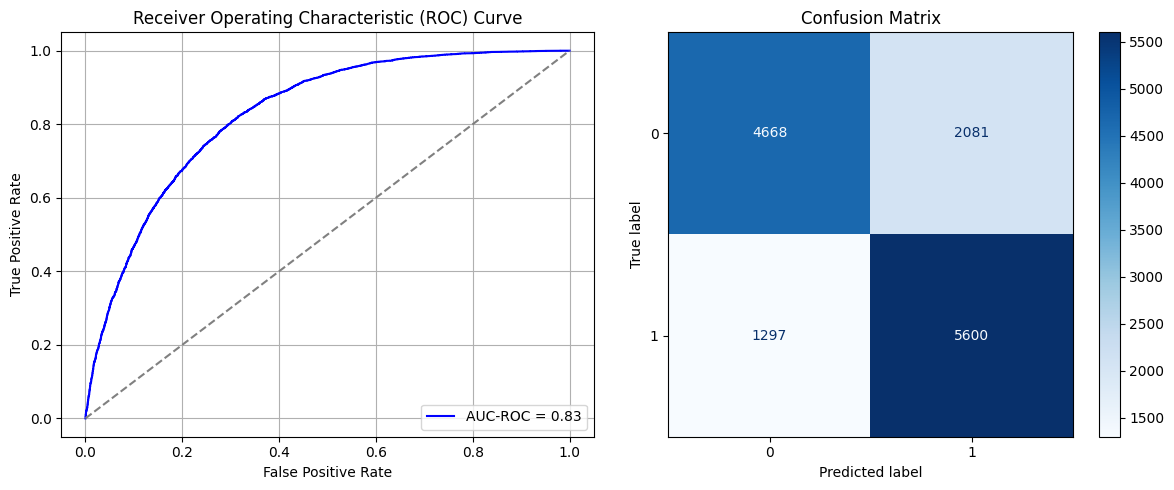

Best threshold based on F1-score: 0.42557650804519653
Time elapsed (performance): 50.026059765000355


In [ ]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7648547499870715
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.37      0.53      2987
           1       0.38      0.93      0.54      1230

    accuracy                           0.54      4217
   macro avg       0.66      0.65      0.54      4217
weighted avg       0.77      0.54      0.54      4217

FPR 0.626380984265149 TPR: 0.373619015734851 FNR: 0.06504065040650407 TNR: 0.9349593495934959


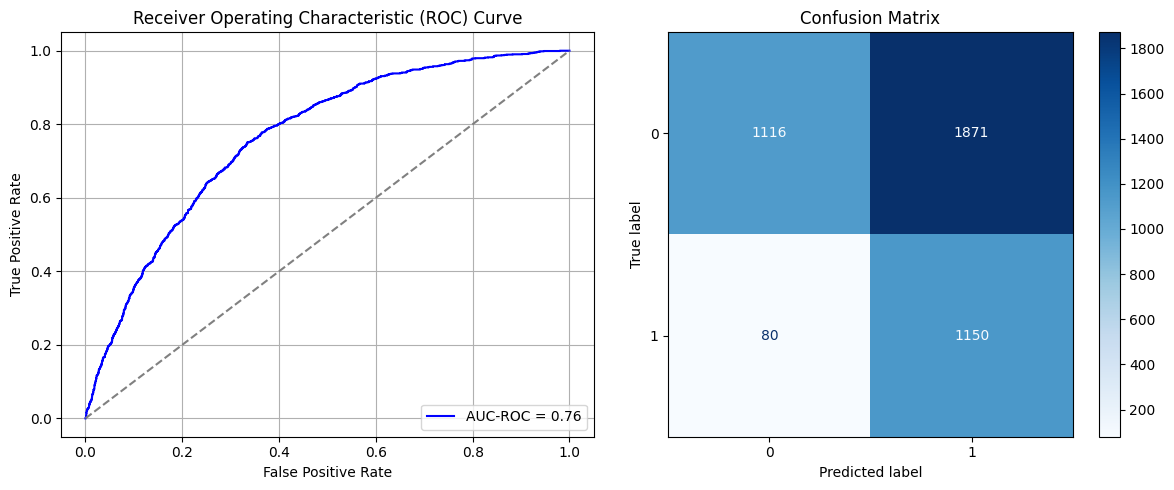

Best threshold based on F1-score: 0.710701584815979
False Negative Rate: 0.06504065040650407
Time elapsed (performance): 0.9007256679997226


In [ ]:
Transductive_TL(model_source_Sy, X_T_full, y_T_full, "Target")

# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [ ]:
data_S
data_S_majority = data_S[data_S['Diabetes_binary'].isin([0])]
data_S_minority = data_S[data_S['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

34116
215347


In [ ]:
np.random.seed(123)
data_S_min_ros = data_S_minority.sample(n=oversample_size - undersample_size, replace=True)
# print(data_S_min_ros)

data_S_SRS_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
# print(data_S_SRS_ROS)

X_S_SRS = data_S_SRS_ROS.iloc[:, :21]
X_S_SRS      ## Source domain


y_S_SRS = data_S_SRS_ROS.iloc[:, 21]
y_S_SRS       ## Source classification (response)

,Diabetes_binary
0,0
1,0
2,0
3,0
4,0
...,...
253636,1
253659,1
253668,1
253670,1


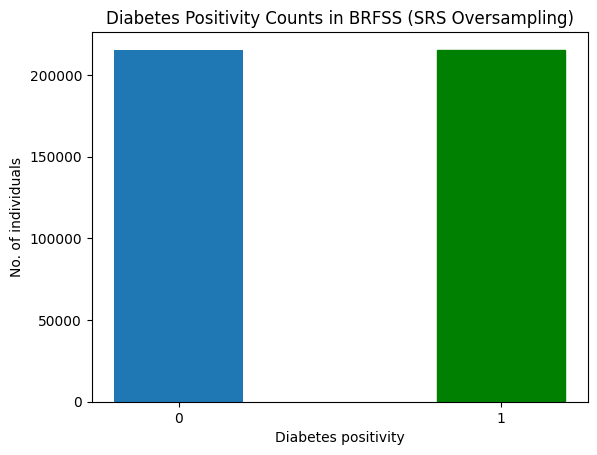

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Oversampling)")
plt.show()

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)

In [ ]:
model_source_SRS_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8104 - loss: 0.5261 - val_AUC: 0.8294 - val_loss: 0.5148
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - AUC: 0.8270 - loss: 0.5058 - val_AUC: 0.8305 - val_loss: 0.5036
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - AUC: 0.8296 - loss: 0.5026 - val_AUC: 0.8324 - val_loss: 0.4993
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8305 - loss: 0.5016 - val_AUC: 0.8329 - val_loss: 0.4981
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8336 - loss: 0.4973 - val_AUC: 0.8328 - val_loss: 0.4987
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8328 - loss: 0.4980 - val_AUC: 0.8331 - val_loss: 0.4999
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8334 - loss: 0.4970 - val_AUC: 0.8328 - val_loss: 0.5000
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - AUC: 0.8332 - loss: 0.4975 - val_AUC: 0.8343 - val_loss: 0.4960
Epoch 9/10
8614/8614 ━━━━━━━━━━━

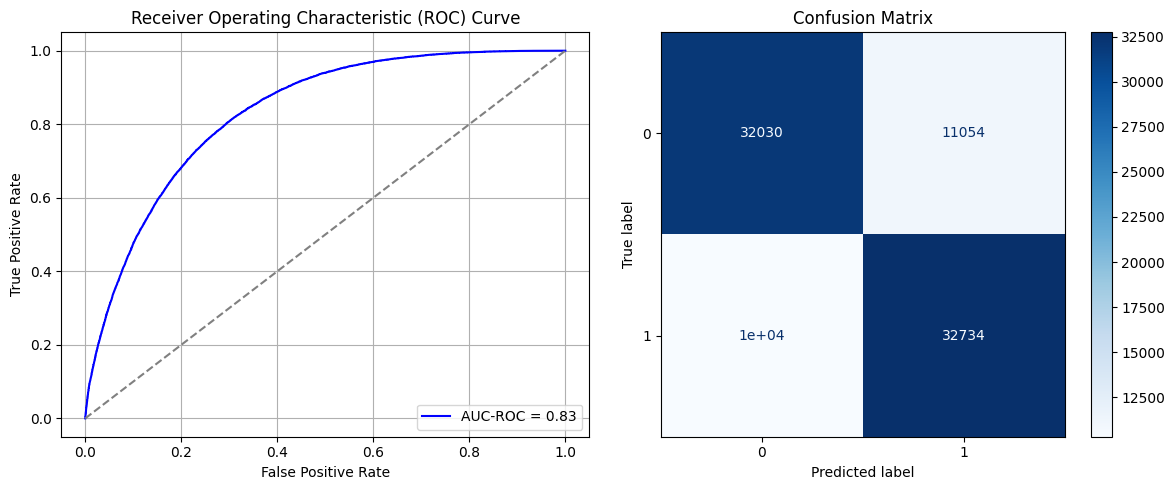

Best threshold based on F1-score: 0.3464154303073883
Time elapsed (performance): 389.960444544


In [ ]:
train_and_evaluate(model_source_SRS_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.758377630980863
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.43      0.58      2987
           1       0.39      0.90      0.55      1230

    accuracy                           0.57      4217
   macro avg       0.65      0.66      0.57      4217
weighted avg       0.76      0.57      0.57      4217

FPR 0.5724807499163039 TPR: 0.42751925008369607 FNR: 0.0975609756097561 TNR: 0.9024390243902439


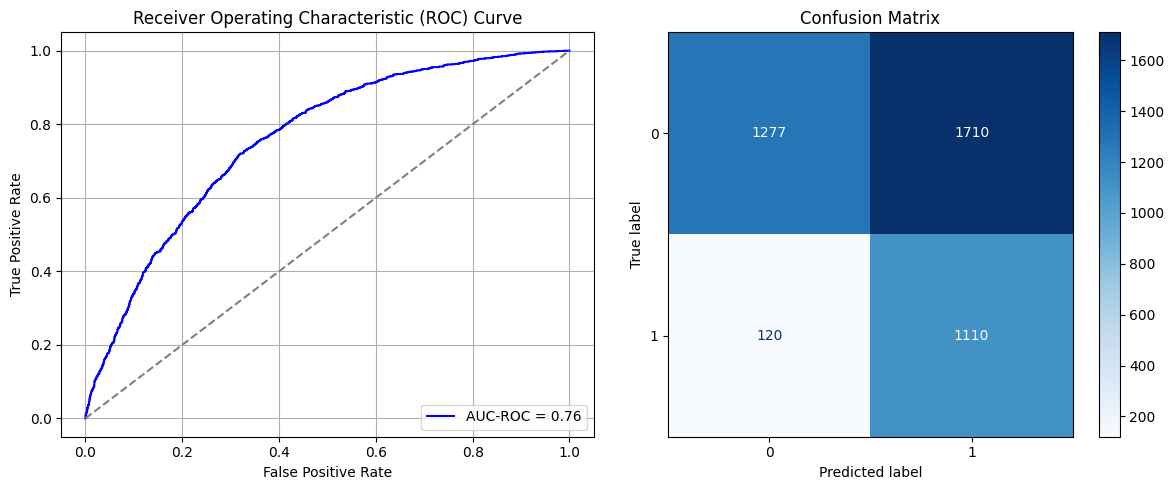

Best threshold based on F1-score: 0.6549074053764343
False Negative Rate: 0.0975609756097561
Time elapsed (performance): 1.329530736000379


In [ ]:
Transductive_TL(model_source_SRS_ROS, X_T_full, y_T_full, "Target")

## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.

In particular, taking $k=48$ yields a number of samples of $k*\frac{N_0-N_1}{N_1}=254.986 \approx 255$, so we take $k=48$.

In [ ]:
import random

k = 48

Nsamples = k*(oversample_size-undersample_size)/undersample_size
# print(Nsamples)

np.random.seed(123)
start = np.random.choice(int(k), int(Nsamples), replace=True)
# print(start)


Row = []

for j in range(len(start)):
  for i in range(int(undersample_size/k)):
    row = start[j]+int(k*i)-1
    Row.append(row)

# print(Row)

data_S_min_ros = pd.DataFrame()
data_S_min_ros = data_S_minority.iloc[Row]

data_S_Sy_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
# print(data_S_SRS_ROS)

X_S_Sy = data_S_Sy_ROS.iloc[:, :21]
X_S_Sy      ## Source domain


y_S_Sy = data_S_Sy_ROS.iloc[:, 21]
y_S_Sy       ## Source classification (response)




,Diabetes_binary
0,0
1,0
2,0
3,0
4,0
...,...
253636,1
253659,1
253668,1
253670,1


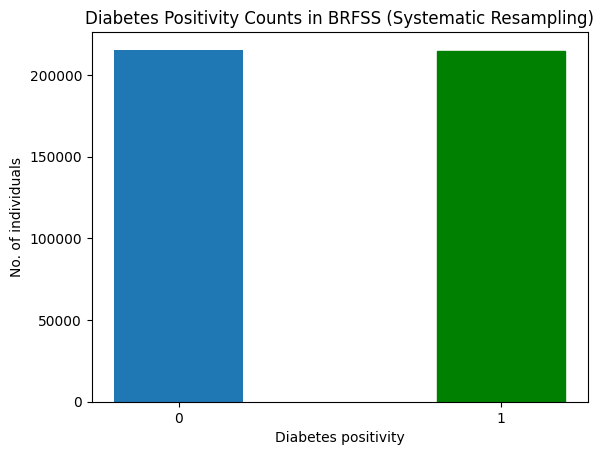

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Resampling)")
plt.show()

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)

In [ ]:
model_source_Sy_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8101 - loss: 0.5266 - val_AUC: 0.8296 - val_loss: 0.5050
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8243 - loss: 0.5091 - val_AUC: 0.8312 - val_loss: 0.5015
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8270 - loss: 0.5052 - val_AUC: 0.8323 - val_loss: 0.4994
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8304 - loss: 0.5010 - val_AUC: 0.8315 - val_loss: 0.5008
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8306 - loss: 0.5005 - val_AUC: 0.8330 - val_loss: 0.4989
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8315 - loss: 0.4992 - val_AUC: 0.8327 - val_loss: 0.4999
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8321 - loss: 0.4979 - val_AUC: 0.8333 - val_loss: 0.4977
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8329 - loss: 0.4976 - val_AUC: 0.8342 - val_loss: 0.4977
Epoch 9/10
8597/8597 ━━━━━━━━━━━

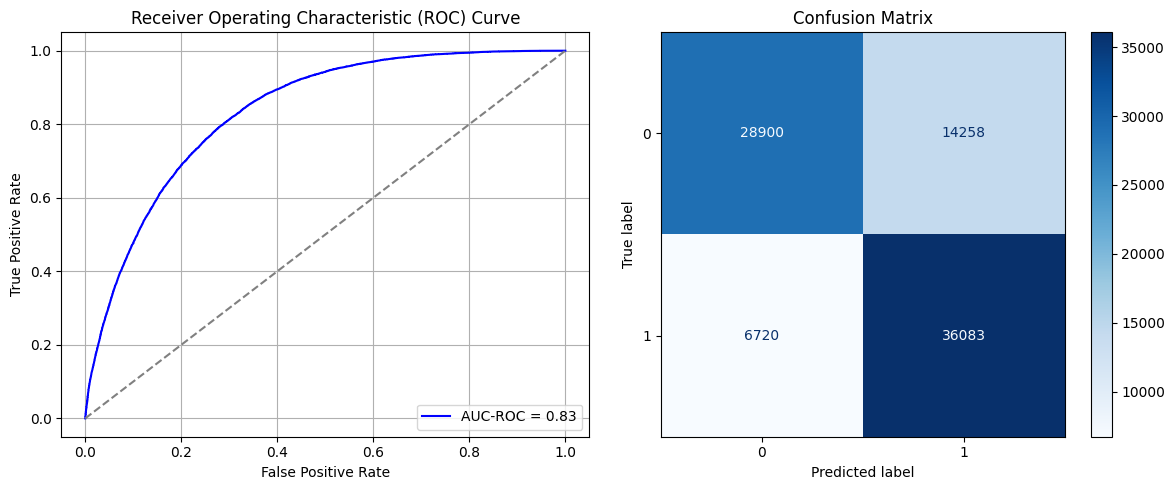

Best threshold based on F1-score: 0.4436500668525696
Time elapsed (performance): 313.1800040859998


In [ ]:
train_and_evaluate(model_source_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7551079066197425
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.34      0.49      2987
           1       0.37      0.94      0.53      1230

    accuracy                           0.51      4217
   macro avg       0.65      0.64      0.51      4217
weighted avg       0.77      0.51      0.50      4217

FPR 0.6628724472715098 TPR: 0.33712755272849015 FNR: 0.06260162601626017 TNR: 0.9373983739837398


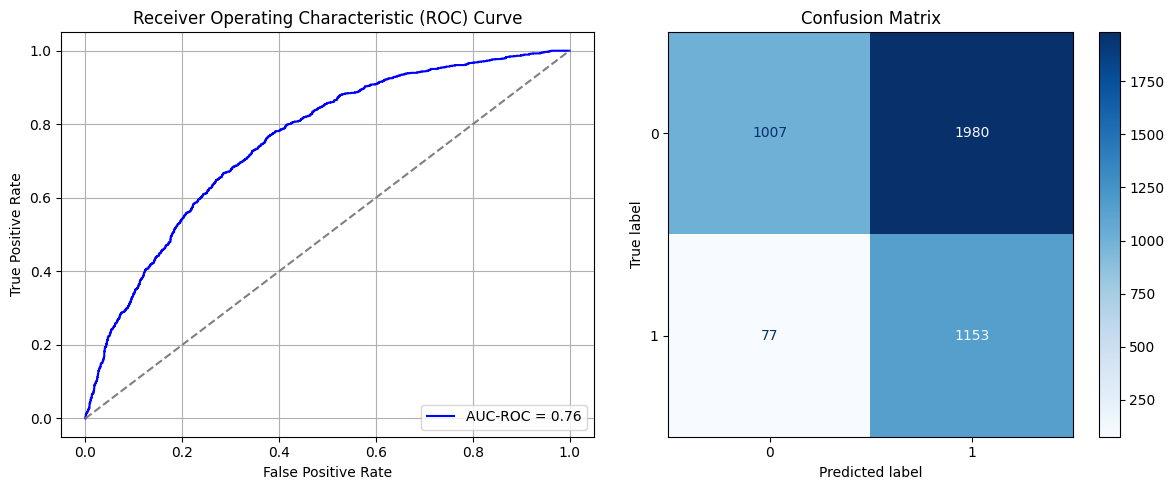

Best threshold based on F1-score: 0.7182944416999817
False Negative Rate: 0.06260162601626017
Time elapsed (performance): 0.9245279090000622


In [ ]:
Transductive_TL(model_source_Sy_ROS, X_T_full, y_T_full, "Target")